# American Census

In [723]:
import numpy as np
import pandas as pd
import copy as copy
import seaborn as sns

from sklearn.naive_bayes import GaussianNB
from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder


import matplotlib.pyplot as plt

## Global config

In [724]:
# Data config
path_to_csv = "adult.csv"

## Load data

In [725]:
pandas_X_train = pd.read_csv("X_train.csv")
pandas_y_train = pd.read_csv("y_train.csv")

pandas_X_test = pd.read_csv("X_test.csv")

## Helpers

In [726]:
# TODO
X_train = pandas_X_train.to_numpy(copy=True)
y_train = pandas_y_train.to_numpy(copy=True)

X_test = pandas_X_test.to_numpy(copy=True)

## Data exploration

### Question 1

In [727]:
unique_elements, counts_elements = np.unique(y_train, return_counts=True)
unique_array = np.asarray((unique_elements, counts_elements))
print(unique_array)
print("From above we can derive that there are an unequal number of samples belonging to each class.")
print("Class distribution for salary <50.000$: ", counts_elements[0]/counts_elements.sum())
print("Class distribution for salary >50.000$: ", counts_elements[1]/counts_elements.sum())

[[    0     1]
 [12360  3920]]
From above we can derive that there are an unequal number of samples belonging to each class.
Class distribution for salary <50.000$:  0.7592137592137592
Class distribution for salary >50.000$:  0.24078624078624078


### Question 2

Based on training data: Men >$50k:  30.51 %, Women >$50k:  11.12 %.
Scaled to account for the difference between the number of men and women: Men >$50k:  15.13 %, Women >$50k:  11.12 %.
This means that the difference is quite insignificant, and thus this parameter isn't necessarily curcial.

Distribution of races:
[(' Amer-Indian-Eskimo', 146), (' Asian-Pac-Islander', 506), (' Black', 1537), (' Other', 138), (' White', 13953)]
The trained model will be highly biased towards the white race! Thus, race is also not quite a good paramter. The white race is found accross 85.71 % of the training data!


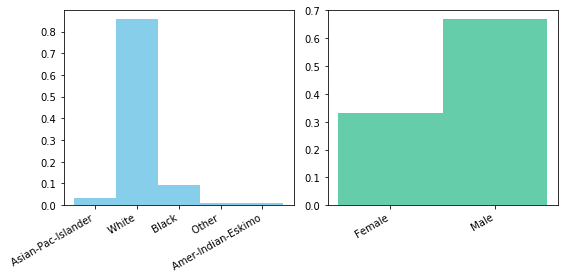

In [728]:
exteded_data = np.c_[X_train, y_train]

num_men = np.where((exteded_data[:, 9] == " Male"))[0].size
num_female = np.where((exteded_data[:, 9] == " Female"))[0].size
females_under_50 = np.where((exteded_data[:, 9] == " Female") & (exteded_data[:, 11] == 0))[0].size
females_over_50 = np.where((exteded_data[:, 9] == " Female") & (exteded_data[:, 11] == 1))[0].size
men_under_50 = np.where((exteded_data[:, 9] == " Male") & (exteded_data[:, 11] == 0))[0].size
men_over_50 = np.where((exteded_data[:, 9] == " Male") & (exteded_data[:, 11] == 1))[0].size

print("Based on training data: Men >$50k: ", round((men_over_50/num_men) * 100, 2) , "%, Women >$50k: ", round(females_over_50/num_female * 100, 2), "%.")
print("Scaled to account for the difference between the number of men and women: Men >$50k: ", round((men_over_50/num_men)/(num_men/num_female) * 100, 2) , "%, Women >$50k: ", round(females_over_50/num_female * 100, 2), "%.")
print("This means that the difference is quite insignificant, and thus this parameter isn't necessarily curcial.")

print()
print("Distribution of races:")
unique_races, counts_races = np.unique(X_train[:, 8], return_counts=True)
zipped = zip(unique_races, counts_races)
print(list(zipped))
print("The trained model will be highly biased towards the white race! Thus, race is also not quite a good paramter. The white race is found accross",
     round(counts_races[4] / X_train.shape[0] * 100, 2), "% of the training data!")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,4), tight_layout=True)
ax1.hist(exteded_data[:, 8], np.arange(0, 4 + 1.5) - 0.5, color="skyblue", density=True)
ax2.hist(exteded_data[:, 9], np.arange(0, 3) - 0.5, color="mediumaquamarine", density=True)
fig.autofmt_xdate()
plt.show()
# Removal of feature is done below

## Data preparations

### Question 1

1576 rows with missing values -> Can't remove 1576 rows since it will affect the training set


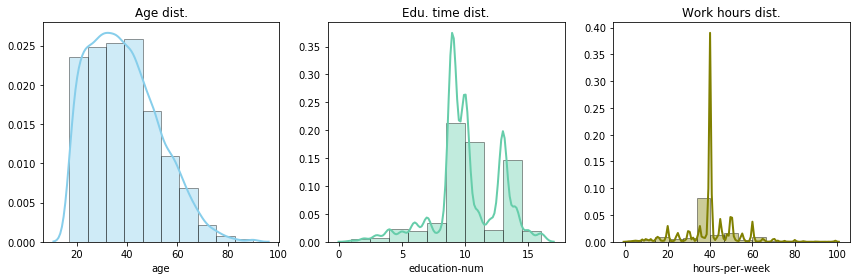

As seen in the plots above, the numerical attributes seem to follow a normal distribution.
Mean Age: 38.60061425061425
Mean Educational years: 10.094139650872817
Mean Work hours per week: 40.39293611793612


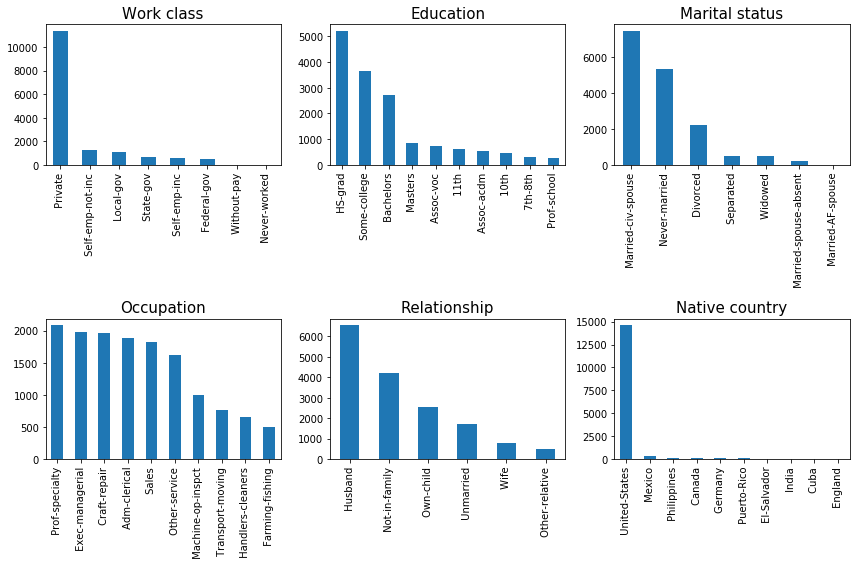

Since there clearly is a separation of classes between the data, most_frequent imputaion tehnique will be used for now.


In [729]:
nan_values = np.where(X_train != X_train)
print(np.unique(nan_values).shape[0], "rows with missing values -> Can't remove 1576 rows since it will affect the training set") 
# Make deep copies
pandas_X_train_copy = copy.deepcopy(pandas_X_train)

# Back-ups
X_train_backup = copy.deepcopy(X_train)
pandas_X_train_backup = copy.deepcopy(pandas_X_train)

# Plotting numerical
fig1, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4), tight_layout=True)
sns.distplot(pandas_X_train_backup["age"], hist=True, kde=True, 
             bins=10, color = 'skyblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 2},
             ax = ax1)
sns.distplot(pandas_X_train_backup["education-num"], hist=True, kde=True, 
             bins=10, color = 'mediumaquamarine', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 2},
             ax = ax2)

sns.distplot(pandas_X_train_backup["hours-per-week"], hist=True, kde=True, 
             bins=15, color = 'olive', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 2},
             ax = ax3)
ax1.set_title("Age dist.")
ax2.set_title("Edu. time dist.")
ax3.set_title("Work hours dist.")
plt.show()

# Conclusions for numerical attributes
print("As seen in the plots above, the numerical attributes seem to follow a normal distribution.")
print("Mean Age:", pandas_X_train_backup["age"].mean())
print("Mean Educational years:", pandas_X_train_backup["education-num"].mean())
print("Mean Work hours per week:", pandas_X_train_backup["hours-per-week"].mean())

# Plotting non-numerical
fig, axarr = plt.subplots(2, 3, figsize=(12, 8), tight_layout=True)
pandas_X_train_backup['workclass'].value_counts().head(10).plot.bar(ax=axarr[0][0])
pandas_X_train_backup['education'].value_counts().head(10).plot.bar(ax=axarr[0][1])
pandas_X_train_backup['marital-status'].value_counts().head(10).plot.bar(ax=axarr[0][2])
pandas_X_train_backup['occupation'].value_counts().head(10).plot.bar(ax=axarr[1][0])
pandas_X_train_backup['relationship'].value_counts().head(10).plot.bar(ax=axarr[1][1])
pandas_X_train_backup['native-country'].value_counts().head(10).plot.bar(ax=axarr[1][2])

axarr[0][0].set_title("Work class", fontsize=15)
axarr[0][1].set_title("Education", fontsize=15)
axarr[0][2].set_title("Marital status", fontsize=15)
axarr[1][0].set_title("Occupation", fontsize=15)
axarr[1][1].set_title("Relationship", fontsize=15)
axarr[1][2].set_title("Native country", fontsize=15)
plt.show()

print("Since there clearly is a separation of classes between the data, most_frequent imputaion tehnique will be used for now.")


# Replace missing numerical values with the median of the column
# Replace missing string values with the most frequent value in the column

# TODO: see iterative immputer!!!
pandas_X_train_copy.fillna(pandas_X_train_copy.mean(), inplace=True)
pandas_X_train_copy.fillna(pandas_X_train_copy.mode(numeric_only=False).iloc[0], inplace=True)

pandas_X_train_copy.drop(["race", "sex"], inplace=True, axis=1) # Remove race & sex from the training dataset
X_train = pandas_X_train_copy.to_numpy(copy=True)

# pandas_X_train_copy & X_train dont have sex & race
# pandas_X_train does

# Update values of pandas_X_train and X_train
pandas_X_train = copy.deepcopy(pandas_X_train_copy)
X_train = pandas_X_train_copy.to_numpy(copy=True)

### Question 2

In [730]:
# Additional preprocessing needs to be done: every non-numerical column has a space before the value <_space_*value*>
# pandas:
pandas_X_train.workclass = pandas_X_train.workclass.str.strip()
pandas_X_train.education = pandas_X_train.education.str.strip()
pandas_X_train["marital-status"] = pandas_X_train["marital-status"].str.strip()
pandas_X_train.occupation = pandas_X_train.occupation.str.strip()
pandas_X_train.relationship = pandas_X_train.relationship.str.strip()
pandas_X_train["native-country"] = pandas_X_train["native-country"].str.strip()

# numpy:
X_train = pandas_X_train.to_numpy(copy=True)

# classes:
workclass = pandas_X_train.workclass.unique()
education = pandas_X_train.education.unique()
marital_status = pandas_X_train["marital-status"].unique()
occupation = pandas_X_train.occupation.unique()
relationship = pandas_X_train.relationship.unique()
native_country = pandas_X_train["native-country"].unique()

# Using OneHotEncoder
encoder = preprocessing.OneHotEncoder(categories=[workclass, education, marital_status, occupation, relationship, native_country], sparse=False)
X_train_categorically_encoded = encoder.fit_transform(X_train[:, 3:])
X_train_encoded = np.c_[X_train[:, :3], X_train_categorically_encoded]

# Using get dummies
pandas_X_train_encoded = pd.get_dummies(pandas_X_train, prefix_sep='_', drop_first=True) # to see - drop_first = True


# Stamdardization & normalization coming


### Question 3

In [731]:
# TODO

## Experiments

### Question 1

In [688]:
# TODO

### Question 2

In [689]:
# TODO

### Question 3

In [690]:
# TODO

### Question 4

In [691]:
#TODO

### Question 5

In [692]:
#TODO
prediction = np.array([-1] * len(X_test)) #TODO replace this with you own prediction
pd.DataFrame(prediction).to_csv("GROUP_classes_problem_census.txt", index=False, header=False)